In [1]:
import pandas as pd
import numpy as np
import mibian
import yfinance as yf

## Ticker Data

In [2]:
#get data on this ticker
tickerData = yf.Ticker("SPY")

#get the historical prices for this ticker
tickerDf = tickerData.history(period="max")

#see your data
tickerDf["returns"] = tickerDf["Close"].pct_change()

## Initial Simulation

In [3]:
mu = np.mean(tickerDf["returns"])
sigma = np.std(tickerDf["returns"])
days_of = 857
start_price = 420

returns = np.random.normal(loc=mu, scale=sigma, size=days_of)
price = start_price*(1+returns).cumprod()

In [6]:
forward = [mibian.BS([price[-d], 210, 0.01, d], volatility=21.63).callPrice for d in range(days_of,0,-1)]
days = [d for d in range(0,days_of,1)]

In [7]:
returns = pd.DataFrame({"Underlying Price": price, "LEAP Price": forward, "Days": days})
returns["LEAP PL"], returns["BnH PL"] = (returns["LEAP Price"] - returns["LEAP Price"][0])*100, (returns["Underlying Price"] - returns["Underlying Price"][0])*100
returns["LEAP Returns(%)"] , returns["BnH Returns(%)"] = (returns["LEAP PL"]/(returns["LEAP Price"][0]*100))*100, (returns["BnH PL"]/(returns["Underlying Price"][0]*100))*100

In [8]:
import plotly.express as px

fig = px.line(returns,x="Days", y=["LEAP Returns(%)", "BnH Returns(%)"], labels={"value":"Profit/Loss (%)", "variable":"Strategy"})
fig.show()

In [57]:
returns["Ext Value"] = ((210+returns["LEAP Price"]) - returns["Underlying Price"])*100

In [58]:
px.line(returns, x="Days", y="Ext Value")

## Multiple Simulation

In [4]:
sim = []

for i in range(0,1000):
    price = start_price*(1+(np.random.normal(loc=mu, scale=sigma, size=days_of))).cumprod()
    LEAP_val = (mibian.BS([price[-1], 210, 0.01, 1], volatility=21.63).callPrice - mibian.BS([price[0], 210, 0.01, days_of], volatility=21.63).callPrice)/ mibian.BS([price[0], 210, 0.01, days_of], volatility=21.63).callPrice
    BnH_val = (price[-1] - price[0] )/ price[0]
    diff = LEAP_val - BnH_val
    sim.append(diff)

In [68]:
fig = px.histogram(sim, nbins=100, title="Histogram of Return Differences (%)", labels={"value":"Differences in % returns"})
fig.update_layout(showlegend=False).update_yaxes(visible=False, showticklabels=False).update_xaxes(nticks=20)
fig.show()

### Matplotlib Plotting

In [24]:
import matplotlib.pyplot as plt

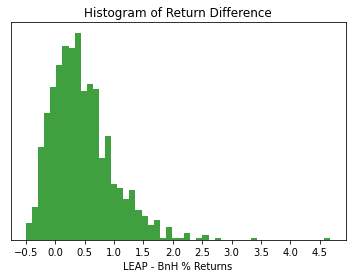

In [61]:
fig, ax = plt.subplots()

n, bins, patches = plt.hist(sim, facecolor="g", alpha=0.75, bins=50)
plt.xlabel("LEAP - BnH % Returns")
ax.set_title("Histogram of Return Difference")
ax.get_yaxis().set_visible(False)
plt.xticks(ticks=np.arange(-0.5,5,0.5))
plt.show()

## Bear Market Returns

In [70]:
bear_day = returns

In [71]:
bear_day

,Underlying Price,LEAP Price,Days,LEAP PL,BnH PL,LEAP Returns(%),BnH Returns(%)
0,422.805055,213.465274,0,0.000000,0.000000,0.000000,0.000000
1,421.125134,211.802206,1,-166.306767,-167.992034,-0.779081,-0.397327
2,429.020837,219.609780,2,614.450629,621.578259,2.878457,1.470130
3,432.878792,223.428145,3,996.287049,1007.373746,4.667209,2.382596
4,422.320352,212.976110,4,-48.916378,-48.470240,-0.229154,-0.114640
...,...,...,...,...,...,...,...
852,295.174564,85.174852,852,-12829.042195,-12763.049028,-60.098966,-30.186605
853,292.632194,82.632424,853,-13083.284978,-13017.286058,-61.289992,-30.787915
854,298.132999,88.133171,854,-12533.210282,-12467.205608,-58.713111,-29.486889
855,291.381856,81.381971,855,-13208.330285,-13142.319858,-61.875780,-31.083639


In [154]:
add_payment_2 = bear_day_2["LEAP Price"].iloc[0] - bear_day["LEAP Price"].iloc[-1]
add_payment_3 = bear_day_3["LEAP Price"].iloc[0] - bear_day["LEAP Price"].iloc[-1]

In [77]:
mu = np.mean(tickerDf["returns"])
sigma = np.std(tickerDf["returns"])
days_of = 857
start_price = 287

returns = np.random.normal(loc=mu, scale=sigma, size=days_of)
price = start_price*(1+returns).cumprod()

forward = [mibian.BS([price[-d], 145, 0.01, d], volatility=21.63).callPrice for d in range(days_of,0,-1)]
days = [d for d in range(0,days_of,1)]

In [142]:
bear_day_2 = pd.DataFrame({"Underlying Price": price, "LEAP Price": forward, "Days": days})
bear_day["Roll_LEAP"] = bear_day["LEAP Price"]
bear_day_2["Roll_LEAP"] = bear_day_2["LEAP Price"] - bear_day["LEAP Price"].iloc[-1]
bear_complete = pd.concat([bear_day, bear_day_2]).reset_index()


In [147]:
bear_complete["Days"] = bear_complete.index
bear_complete["LEAP PL"], bear_complete["BnH PL"] = (bear_complete["Roll_LEAP"] - bear_complete["Roll_LEAP"][0])*100, (bear_complete["Underlying Price"] - bear_complete["Underlying Price"][0])*100
bear_complete["LEAP Returns(%)"] , bear_complete["BnH Returns(%)"] = (bear_complete["LEAP PL"]/((bear_complete["Roll_LEAP"][0]+bear_day_2["LEAP Price"].iloc[0] - bear_day["LEAP Price"].iloc[-1])*100))*100, (bear_complete["BnH PL"]/(bear_complete["Underlying Price"][0]*100))*100

In [176]:
fig = px.line(bear_complete,x="Days", y=["LEAP Returns(%)", "BnH Returns(%)"], labels={"value":"Profit/Loss (%)", "variable":"Strategy"})
fig.show()

### Bear Market - HTS

In [135]:
buy_LEAP_HTS = [mibian.BS([bear_day_2["Underlying Price"].iloc[-d], 210, 0.01, d], volatility=21.63).callPrice for d in range(days_of,0,-1)]
days = [d for d in range(0,days_of,1)]

In [151]:
bear_day_3 = pd.DataFrame({"Underlying Price": bear_day_2["Underlying Price"], "LEAP Price": buy_LEAP_HTS, "Days": days})
bear_day_3["Roll_LEAP"] = bear_day_3["LEAP Price"] - bear_day["LEAP Price"].iloc[-1]
bear_complete_2 = pd.concat([bear_day, bear_day_3]).reset_index()

In [155]:
bear_complete_2["Days"] = bear_complete_2.index
bear_complete_2["LEAP PL"], bear_complete_2["BnH PL"] = (bear_complete_2["Roll_LEAP"] - bear_complete_2["Roll_LEAP"][0])*100, (bear_complete_2["Underlying Price"] - bear_complete_2["Underlying Price"][0])*100
bear_complete_2["LEAP Returns(%)"] , bear_complete_2["BnH Returns(%)"] = (bear_complete_2["LEAP PL"]/((bear_complete_2["Roll_LEAP"][0]+add_payment_3)*100))*100, (bear_complete_2["BnH PL"]/(bear_complete_2["Underlying Price"][0]*100))*100

In [156]:
fig = px.line(bear_complete_2,x="Days", y=["LEAP Returns(%)", "BnH Returns(%)"], labels={"value":"Profit/Loss (%)", "variable":"Strategy"})
fig.show()

In [157]:
bear_complete_2

,index,Underlying Price,LEAP Price,Days,LEAP PL,BnH PL,LEAP Returns(%),BnH Returns(%),Roll_LEAP
0,0,422.805055,213.465274,0,0.000000,0.000000,0.000000,0.000000,213.465274
1,1,421.125134,211.802206,1,-166.306767,-167.992034,-0.750261,-0.397327,211.802206
2,2,429.020837,219.609780,2,614.450629,621.578259,2.771976,1.470130,219.609780
3,3,432.878792,223.428145,3,996.287049,1007.373746,4.494557,2.382596,223.428145
4,4,422.320352,212.976110,4,-48.916378,-48.470240,-0.220677,-0.114640,212.976110
...,...,...,...,...,...,...,...,...,...
1709,852,417.255660,207.255948,1709,-8420.707404,-554.939420,-37.988400,-1.312518,129.258200
1710,853,418.791579,208.791809,1710,-8267.121278,-401.347540,-37.295525,-0.949250,130.794061
1711,854,424.880859,214.881031,1711,-7658.199086,207.580406,-34.548490,0.490960,136.883283
1712,855,429.820430,219.820545,1712,-7164.247721,701.537524,-32.320124,1.659246,141.822797


In [158]:
bear_complete

,index,Underlying Price,LEAP Price,Days,LEAP PL,BnH PL,LEAP Returns(%),BnH Returns(%),Roll_LEAP,Roll_LEAP_HTS
0,0,422.805055,213.465274,0,0.000000,0.000000,0.000000,0.000000,213.465274,NaN
1,1,421.125134,211.802206,1,-166.306767,-167.992034,-0.594206,-0.397327,211.802206,NaN
2,2,429.020837,219.609780,2,614.450629,621.578259,2.195403,1.470130,219.609780,NaN
3,3,432.878792,223.428145,3,996.287049,1007.373746,3.559687,2.382596,223.428145,NaN
4,4,422.320352,212.976110,4,-48.916378,-48.470240,-0.174776,-0.114640,212.976110,NaN
...,...,...,...,...,...,...,...,...,...,...
1709,852,417.255660,272.255859,1709,-620.932587,-554.939420,-2.218563,-1.312518,207.255948,207.255948
1710,853,418.791579,273.791738,1710,-467.346461,-401.347540,-1.669807,-0.949250,208.791809,208.791809
1711,854,424.880859,279.880978,1711,141.575731,207.580406,0.505843,0.490960,214.881031,214.881031
1712,855,429.820430,284.820509,1712,635.527096,701.537524,2.270708,1.659246,219.820545,219.820545


In [161]:
ext_val = ((210+bear_day_3["LEAP Price"]) - bear_day_3["Underlying Price"])*100

In [168]:
px.line(ext_val, labels={"index":"Days", "value":"Extrinsic Value"}).update_layout(showlegend=False)

In [171]:
delta_ITM = [mibian.BS([bear_day_2["Underlying Price"].iloc[-d], 145, 0.01, d], volatility=21.63).callDelta for d in range(days_of,0,-1)]
delta_NITM = [mibian.BS([bear_day_2["Underlying Price"].iloc[-d], 210, 0.01, d], volatility=21.63).callDelta for d in range(days_of,0,-1)]

In [172]:
delta_compare = pd.DataFrame(
    {"Hold Strike Delta" : delta_NITM,
    "ITM Delta" : delta_ITM}
)

In [175]:
px.line(delta_compare, y=["Hold Strike Delta", "ITM Delta"], labels={"index":"Days", "value":"Delta","variable":"Strategy"})